<a href="https://colab.research.google.com/github/SMN-SENAMHI/S2S/blob/main/tmax.tmin.tmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies required for this example.
# If you're not using pip to install depdencies (for example, you're using conda or uv),
# skip this cell and and install using the package manager of your choice.
# Restart the notebook after installing dependencies.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... D

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Parámetros de entrada ===
lugar = "Lima"
lat_lugar = -12.0
lon_lugar = -77.0
init_time = "2025-07-02T00"  # Fecha inicial del pronóstico

# === Cargar datos GEFS desde Zarr ===
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)

# Seleccionar la variable y coordenada más cercana
ds_var = ds["minimum_temperature_2m"].sel(
    init_time=init_time,
    latitude=lat_lugar,
    longitude=lon_lugar,
    method="nearest"
)

# Crear coordenada de tiempo completa
forecast_time = pd.to_datetime(ds_var.init_time.values) + pd.to_timedelta(ds_var.lead_time.values, unit="h")
ds_var = ds_var.assign_coords(forecast_time=("lead_time", forecast_time)).swap_dims({"lead_time": "forecast_time"})

# Crear coordenada "date" con resolución diaria (sin horas)
ds_var = ds_var.assign_coords(date=("forecast_time", ds_var.forecast_time.dt.floor("D").data))

# Agrupar por fecha y promediar por miembro
ds_daily = ds_var.groupby("date").mean()

# Limitar a primeros 35 días
ds_daily = ds_daily.isel(date=slice(0, 35))

# === Configuración de colores ===
color_miembros = "#B39DDB"   # violeta suave
color_media = "#5E35B1"      # violeta oscuro

# === Graficar ===
plt.figure(figsize=(14, 7))
for member in ds_daily.ensemble_member.values:
    plt.plot(ds_daily.date, ds_daily.sel(ensemble_member=member), color=color_miembros, alpha=0.5)

# Media del ensamble
media = ds_daily.mean(dim="ensemble_member")
plt.plot(ds_daily.date, media, color=color_media, linewidth=2.5, label="Media del ensamble")

# === Personalización del gráfico ===
plt.title(f"GEFS - Temperatura mínima diaria en {lugar} (Init: {init_time})", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Temperatura mínima [°C]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-3-2354796769.py:13: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
/tmp/ipython-input-3-2354796769.py:13: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)


/tmp/ipython-input-4-945274476.py:30: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)
/tmp/ipython-input-4-945274476.py:30: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)


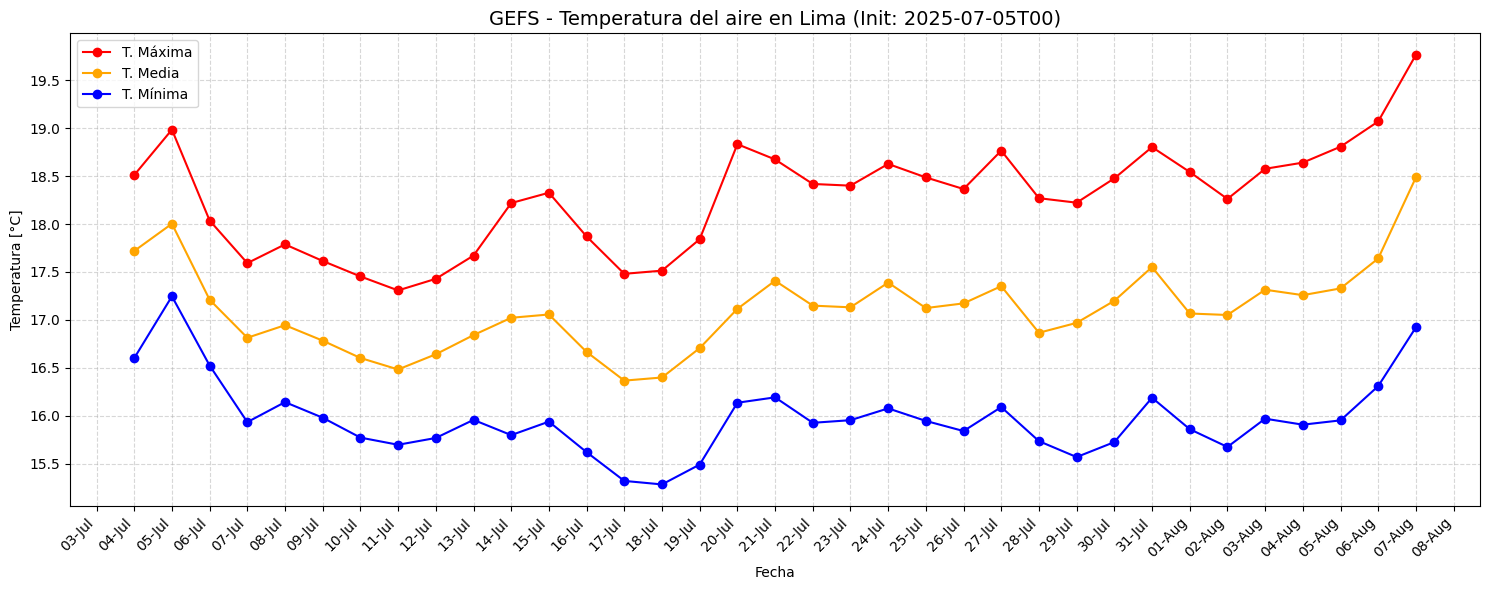

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import pandas as pd

# 📍 Coordenadas para Cusco, Perú
#lugar= "Cusco"
#lat_lima = -13.5320
#lon_lima = -71.9675

#COLOCAR COORDENADA PARA LIMA
lugar= "Lima"
lat_lima = -12.0
lon_lima = -77.0

#📍 PUERTO MALDONADO PERU
#lugar= "Puerto Maldonado"
#lat_lima = -12.5933
#lon_lima = -69.1899


# Fecha inicial
init_time = "2025-07-04T00"

# Variables a extraer
vars_needed = ["maximum_temperature_2m", "temperature_2m", "minimum_temperature_2m"]

# Abrir dataset
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr", consolidated=True)

# Seleccionar punto más cercano
ds = ds[vars_needed].sel(init_time=init_time, latitude=lat_lima, longitude=lon_lima, method="nearest")

# Crear coordenada forecast_time
forecast_time = pd.to_datetime(ds.init_time.values) + pd.to_timedelta(ds.lead_time.values, unit="h")
ds = ds.assign_coords(forecast_time=("lead_time", forecast_time)).swap_dims({"lead_time": "forecast_time"})

# Promedio diario y del ensamble
ds_daily = ds.resample(forecast_time="1D").mean(dim=["forecast_time", "ensemble_member"])

# Limitar a primeros 35 días
ds_daily = ds_daily.isel(forecast_time=slice(0, 35))
fechas = ds_daily.forecast_time.values

# Graficar
plt.figure(figsize=(15, 6))
plt.plot(fechas, ds_daily["maximum_temperature_2m"], label="T. Máxima", color="red", marker='o')
plt.plot(fechas, ds_daily["temperature_2m"], label="T. Media", color="orange", marker='o')
plt.plot(fechas, ds_daily["minimum_temperature_2m"], label="T. Mínima", color="blue", marker='o')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
plt.xticks(rotation=45, ha="right")
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))

#plt.title("GEFS - Temperatura diaria promedio del ensamble en Cusco (init: 2025-07-05)")
plt.title(f"GEFS - Temperatura del aire en {lugar} (Init: {init_time})", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Temperatura [°C]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
